In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecVideoRecorder
import os 
import do_mpc
from casadi import vertcat
from scipy.linalg import solve_discrete_are

## Train the RL models

In [34]:
rl_train_steps = 1000000

# Create 'Results' folder if it doesn't exist
results_folder = "Results/Trained_Models/"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train PPO model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=rl_train_steps)
ppo_model.save(os.path.join(results_folder, "ppo_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save PPO model
env.close()

#------------------------------------------------------------------------------------------------------------------------------------------------
# Train DQN model
#------------------------------------------------------------------------------------------------------------------------------------------------
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
dqn_model = DQN("MlpPolicy", env, verbose=1)
dqn_model.learn(total_timesteps=rl_train_steps)
dqn_model.save(os.path.join(results_folder, "dqn_cartpole_model_training_steps_" + str(rl_train_steps)))  # Save DQN model

env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.4     |
|    ep_rew_mean     | 23.4     |
| time/              |          |
|    fps             | 3862     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.7        |
|    ep_rew_mean          | 29.7        |
| time/                   |             |
|    fps                  | 2227        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009253284 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss   

## Specify the MPC model

In [ ]:
class MPCController:
    def __init__(self, horizon=10, dt=0.02, linear=False, recompute_every=1):
        self.horizon = horizon
        self.dt = dt
        self.linear = linear  # New parameter
        self.recompute_every = recompute_every
        self.force_mag = 10.0
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.length = 0.5
        self.total_mass = self.masscart + self.masspole
        self.polemass_length = self.masspole * self.length

        # Define model
        model_type = "continuous"
        self.model = do_mpc.model.Model(model_type)
        
        x = self.model.set_variable(var_type='_x', var_name='x', shape=(1,1))
        x_dot = self.model.set_variable(var_type='_x', var_name='x_dot', shape=(1,1))
        theta = self.model.set_variable(var_type='_x', var_name='theta', shape=(1,1))
        theta_dot = self.model.set_variable(var_type='_x', var_name='theta_dot', shape=(1,1))
        u = self.model.set_variable(var_type='_u', var_name='u', shape=(1,1))
        
        if self.linear:
            # Linearized dynamics (θ ≈ 0)
            temp = u / self.total_mass  # Ignore θ_dot² term
            thetaacc = (self.gravity * theta - temp) / (
                self.length * (4.0/3.0 - self.masspole/self.total_mass)
            )
            xacc = temp - self.polemass_length * thetaacc / self.total_mass
        else:
            # Original nonlinear dynamics
            costheta = np.cos(theta)
            sintheta = np.sin(theta)
            temp = (u + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
            thetaacc = (self.gravity * sintheta - costheta * temp) / (
                self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass)
            )
            xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        
        self.model.set_rhs('x', x_dot)
        self.model.set_rhs('x_dot', xacc)
        self.model.set_rhs('theta', theta_dot)
        self.model.set_rhs('theta_dot', thetaacc)
        
        self.model.setup()
        
        # Configure MPC based on linearity
        self.mpc = do_mpc.controller.MPC(self.model)
        setup_mpc = {
            'n_horizon': self.horizon,
            't_step': self.dt,
            'n_robust': 0,
            'state_discretization': 'discrete' if self.linear else 'collocation',
            'collocation_type': 'radau' if not self.linear else None,
            'collocation_deg': 2 if not self.linear else None,
            'collocation_ni': 1 if not self.linear else None,
            'store_full_solution': False,
        }
        self.mpc.set_param(**{k: v for k, v in setup_mpc.items() if v is not None})
       
        self.mpc.set_objective(mterm=theta**2 + x**2, lterm=theta**2 + x**2 + 0.01*u**2)
        self.mpc.bounds['lower','_u','u'] = -self.force_mag
        self.mpc.bounds['upper','_u','u'] = self.force_mag
        
        self.mpc.setup()

    def get_action(self, obs):
        self.mpc.x0 = np.array(obs).reshape(-1, 1)
        self.mpc.set_initial_guess()
        u_opt = self.mpc.make_step(self.mpc.x0)
        return float(u_opt[0])

## Specify the LQR model

In [10]:
class LQRController:
    def __init__(self, horizon=10, dt=0.02, linear=False, recompute_every=1):
        # Parameters (some may be ignored for LQR)
        self.dt = dt
        self.force_mag = 10.0
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.length = 0.5
        self.total_mass = self.masscart + self.masspole
        self.polemass_length = self.masspole * self.length

        # Linearized dynamics matrices (continuous-time)
        denominator_theta = self.length * (4/3 - self.masspole / self.total_mass)
        a23 = - (self.polemass_length * self.gravity) / (self.total_mass * denominator_theta)
        a43 = self.gravity / denominator_theta
        b21 = (1/self.total_mass) + (self.polemass_length) / (self.total_mass**2 * denominator_theta)
        b41 = -1 / (self.total_mass * denominator_theta)

        A = np.array([
            [0, 1, 0, 0],
            [0, 0, a23, 0],
            [0, 0, 0, 1],
            [0, 0, a43, 0]
        ])
        B = np.array([[0], [b21], [0], [b41]])

        # Discretize using Euler approximation
        A_d = np.eye(4) + A * self.dt
        B_d = B * self.dt

        # Cost matrices (match MPC's objective)
        Q = np.diag([1.0, 0.0, 1.0, 0.0])  # Penalize x and theta
        R = np.array([[0.01]])              # Penalize control effort

        # Solve Discrete Algebraic Riccati Equation
        P = solve_discrete_are(A_d, B_d, Q, R)
        self.K = np.linalg.inv(B_d.T @ P @ B_d + R) @ (B_d.T @ P @ A_d)

    def get_action(self, obs):
        x = np.array(obs).reshape(-1, 1)  # Convert to column vector
        u = -self.K @ x                   # Optimal control law: u = -Kx
        return float(u[0, 0])

## Test the models

In [21]:
SEED = 42
rl_train_steps = 1000000
num_episodes = 20
horizons = [1,10,20,30,40,50, 60,70,80,90,100]
# horizons = [60,70,80,90,100]
recompute_intervals = [1, 5, 10]
# noise_scale = np.array([0.1, 0.1, 0.01, 0.01]) # Noise for cart position, cart velocity, pole angle, pole angular velocity
noise_scale = np.array([0.5, 0.5, 0.05, 0.05]) # Noise for cart position, cart velocity, pole angle, pole angular velocity


# Ensure results folder exists
results_folder = "Results/PerformanceResults/"
os.makedirs(results_folder, exist_ok=True)

# #------------------------------------------------------------------------------------------------------------------------------------------------
# # Evaluate the RL models
# #------------------------------------------------------------------------------------------------------------------------------------------------

# # Load models
# ppo_model = PPO.load(os.path.join(results_folder, f"ppo_cartpole_model_training_steps_{rl_train_steps}"))
# dqn_model = DQN.load(os.path.join(results_folder, f"dqn_cartpole_model_training_steps_{rl_train_steps}"))
# print("Loaded PPO and DQN models.")

# # Modified evaluation function
# def evaluate_model(model, model_name):
#     episode_lengths = []
#     for episode in range(num_episodes):
#         # Only record video for first episode
#         if episode == 0:
#             test_env = gym.make("CartPole-v1", render_mode="rgb_array")
#             video_filename = f"Results/Videos/{model_name}/rl_training_steps_{rl_train_steps}_episode_1_noise_{str(noise_scale).replace('.', '_')}.mp4"
#             test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda _: True)
#         else:
#             # Disable rendering for subsequent episodes
#             test_env = gym.make("CartPole-v1", render_mode=None)

#         obs, _ = test_env.reset(seed=SEED+episode)
#         episode_length = 0
#         done = False
        
#         while not done and episode_length < 500:
#             action, _ = model.predict(obs, deterministic=True)
#             obs, _, done, _, _ = test_env.step(action)
#             rng = np.random.default_rng(seed=SEED + episode + episode_length)  
#             obs += rng.normal(loc=0, scale=noise_scale)  
#             episode_length += 1
            
#         episode_lengths.append(episode_length)
#         test_env.close()
#     return episode_lengths

# # Evaluate PPO and DQN models
# ppo_episode_lengths = evaluate_model(ppo_model, "ppo")
# dqn_episode_lengths = evaluate_model(dqn_model, "dqn")

# # Save the results (unchanged)
# results_folder = "Results/PerformanceResults/"
# os.makedirs(results_folder, exist_ok=True)
# np.savetxt(os.path.join(results_folder, f"ppo_episode_lengths_rl_training_steps_{rl_train_steps}_noise_{str(noise_scale).replace('', '_')}.csv"), ppo_episode_lengths, delimiter=",")
# np.savetxt(os.path.join(results_folder, f"dqn_episode_lengths_rl_training_steps_{rl_train_steps}_noise_{str(noise_scale).replace('', '_')}.csv"), dqn_episode_lengths, delimiter=",")

# #------------------------------------------------------------------------------------------------------------------------------------------------
# # Evaluate the MPC models
# #------------------------------------------------------------------------------------------------------------------------------------------------

# mpc_results = {}
# for horizon in horizons:
#     for recompute_every in recompute_intervals:
#         key = f"h_{horizon}_e_{recompute_every}"
#         mpc_results[key] = []
#         mpc = MPCController(horizon=horizon, recompute_every=recompute_every)
        
#         for episode in range(num_episodes):
#             # First episode gets video recording
#             if episode == 0:
#                 test_env = gym.make("CartPole-v1", render_mode="rgb_array")
#                 video_filename = f"Results/Videos/mpc_horizon_{horizon}_recompute_{recompute_every}_noise_{str(noise_scale).replace('.', '_')}/episode_1.mp4"
#                 test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda _: True)
#             else:
#                 # Subsequent episodes have no rendering
#                 test_env = gym.make("CartPole-v1", render_mode=None)

#             obs, _ = test_env.reset(seed=SEED+episode)
#             episode_length = 0
#             step = 0
#             done = False
            
#             while not done and episode_length < 500:
#                 if step % recompute_every == 0:
#                     action = 1 if mpc.get_action(obs) > 0 else 0
#                 obs, _, done, _, _ = test_env.step(action)
#                 rng = np.random.default_rng(seed=SEED + episode + episode_length)  
#                 obs += rng.normal(loc=0, scale=noise_scale)  
#                 step += 1
#                 episode_length += 1
                
#             mpc_results[key].append(episode_length)
#             test_env.close()

# # Save results
# results_folder = "Results/PerformanceResults/"
# os.makedirs(results_folder, exist_ok=True)
# for key, lengths in mpc_results.items():
#     np.savetxt(os.path.join(results_folder, f"mpc_episode_lengths_{key}_noise_{str(noise_scale).replace('', '_')}.csv"), lengths, delimiter=",")


#------------------------------------------------------------------------------------------------------------------------------------------------
# Evaluate the LQR model
#------------------------------------------------------------------------------------------------------------------------------------------------

lqr_results = {}
horizons = [10]       # Not used by LQR but kept for structure
recompute_intervals = [1]  # LQR should always recompute every step

for horizon in horizons:
    for recompute_every in recompute_intervals:
        key = f"h_{horizon}_e_{recompute_every}"
        lqr_results[key] = []
        lqr = LQRController(horizon=horizon, recompute_every=recompute_every)
        
        for episode in range(num_episodes):
            if episode == 0:
                test_env = gym.make("CartPole-v1", render_mode="rgb_array")
                video_filename = f"Results/Videos/lqr_horizon_{horizon}_recompute_{recompute_every}_noise_{str(noise_scale).replace('.', '_')}/episode_1.mp4"
                test_env = gym.wrappers.RecordVideo(test_env, video_filename, episode_trigger=lambda _: True)
            else:
                test_env = gym.make("CartPole-v1", render_mode=None)

            obs, _ = test_env.reset(seed=SEED+episode)
            episode_length = 0
            step = 0
            done = False
            
            while not done and episode_length < 500:
                if step % recompute_every == 0:
                    action = 1 if lqr.get_action(obs) > 0 else 0
                obs, _, done, _, _ = test_env.step(action)
                rng = np.random.default_rng(seed=SEED + episode + episode_length)  
                obs += rng.normal(loc=0, scale=noise_scale)  
                step += 1
                episode_length += 1
                
            lqr_results[key].append(episode_length)
            test_env.close()

# Save results
for key, lengths in lqr_results.items():
    np.savetxt(os.path.join(results_folder, f"lqr_episode_lengths_{key}_noise_{str(noise_scale).replace('', '_')}.csv"), lengths, delimiter=",")


c:\Users\igrahek\AppData\Local\anaconda3\envs\shitty_bird_env\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\igrahek\Brown Dropbox\Ivan Grahek\Ivan\Studies\MPC\mpc_dojo\Ivan\MPC_RL_Cartpole\Results\Videos\lqr_horizon_10_recompute_1_noise_[0_5  0_5  0_05 0_05]\episode_1.mp4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [23]:
num_episodes = 20

# Get all the files in the Results/PerformanceResults folder
results_folder = "Results/PerformanceResults/"
files = os.listdir(results_folder)

# Take only the files that end with .csv
files = [file for file in files if file.endswith(".csv")]

# Take only the files that end with specific noise
noise_scale = np.array([0.1, 0.1, 0.01, 0.01]) # Noise for cart position, cart velocity, pole angle, pole angular velocity
# noise_scale = np.array([0.5, 0.5, 0.05, 0.05]) # Noise for cart position, cart velocity, pole angle, pole angular velocity
files = [file for file in files if file.endswith(f"_noise_{str(noise_scale).replace('', '_')}.csv")]

# Read each of the files and calculate the mean and standard deviation of the episode lengths. save the model name (first 3 letters of the file name), and the model specification after the 2nd underscore
results = []
for file in files:
    data = np.loadtxt(os.path.join(results_folder, file), delimiter=",")
    mean = np.mean(data)
    std = np.std(data)
    model_name = file[:3]
    model_spec = file.split("_")[3:]
    model_spec = model_spec[:model_spec.index('noise')]
    results.append([model_name, model_spec, mean, std])
results


[['dqn', ['rl', 'training', 'steps', '1000000'], 165.65, 11.235101245649723],
 ['dqn', ['rl', 'training', 'steps', '100000'], 204.8, 31.208332220738743],
 ['dqn', ['rl', 'training', 'steps', '10000'], 9.5, 0.6708203932499369],
 ['dqn', ['rl', 'training', 'steps', '1000'], 10.5, 1.2041594578792296],
 ['lqr', ['h', '10', 'e', '1'], 500.0, 0.0],
 ['mpc', ['h', '100', 'e', '10'], 9.95, 0.3840572873934304],
 ['mpc', ['h', '100', 'e', '1'], 500.0, 0.0],
 ['mpc', ['h', '100', 'e', '5'], 135.1, 110.4273064056169],
 ['mpc', ['h', '10', 'e', '10'], 9.85, 0.4769696007084728],
 ['mpc', ['h', '10', 'e', '1'], 88.4, 18.937792902025304],
 ['mpc', ['h', '10', 'e', '5'], 67.6, 17.310112651279887],
 ['mpc', ['h', '1', 'e', '10'], 9.85, 0.4769696007084728],
 ['mpc', ['h', '1', 'e', '1'], 70.95, 16.12908862893375],
 ['mpc', ['h', '1', 'e', '5'], 27.9, 10.830050784737805],
 ['mpc', ['h', '20', 'e', '10'], 9.9, 0.43588989435406733],
 ['mpc', ['h', '20', 'e', '1'], 120.2, 30.959005151974765],
 ['mpc', ['h', 

## Plot the results

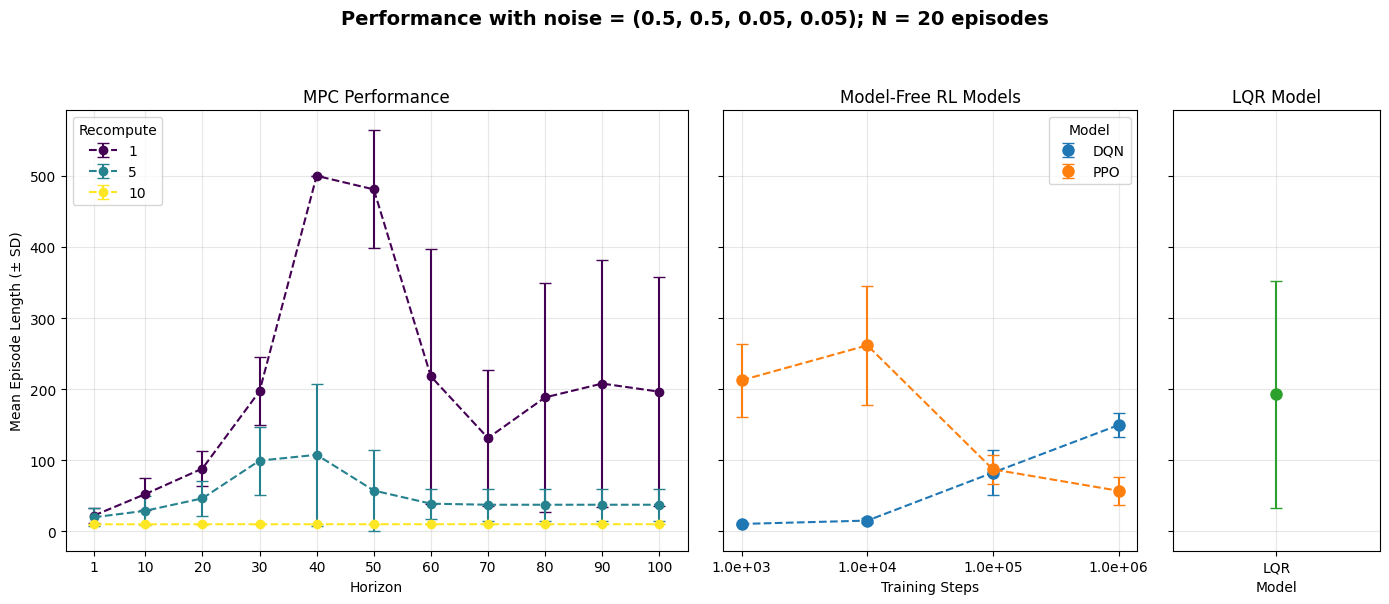

In [32]:
num_episodes = 20

# Get all the files in the Results/PerformanceResults folder
results_folder = "Results/PerformanceResults/"
files = os.listdir(results_folder)

# Take only the files that end with .csv
files = [file for file in files if file.endswith(".csv")]

# Take only the files that end with specific noise
# noise_scale = np.array([0.1, 0.1, 0.01, 0.01]) # Noise for cart position, cart velocity, pole angle, pole angular velocity
noise_scale = np.array([0.5, 0.5, 0.05, 0.05]) # Noise for cart position, cart velocity, pole angle, pole angular velocity
files = [file for file in files if file.endswith(f"_noise_{str(noise_scale).replace('', '_')}.csv")]

# Read each of the files and calculate the mean and standard deviation of the episode lengths. save the model name (first 3 letters of the file name), and the model specification after the 2nd underscore
results = []
for file in files:
    data = np.loadtxt(os.path.join(results_folder, file), delimiter=",")
    mean = np.mean(data)
    std = np.std(data)
    model_name = file[:3]
    model_spec = file.split("_")[3:]
    model_spec = model_spec[:model_spec.index('noise')]
    results.append([model_name, model_spec, mean, std])
results

# For dqn and ppo, reduce the second variable to the 4th element minus .csv. For mpc, reduce the second variable to the combination of all elements minus .csv
for i, result in enumerate(results):
    if result[0] in ["dqn", "ppo"]:
        results[i][1] = result[1][3]
    else:
        results[i][1] = "_".join(result[1][:])
results

# Make a barplot with the mean episode lengths and standard deviations. Make dqn go first, then ppo, then mpc
results.sort(key=lambda x: x[0])
results.sort(key=lambda x: x[0] != "mpc")

# Make a dataframe
df = pd.DataFrame(results, columns=["Model", "Specification", "Mean Episode Length", "Standard Deviation"])

# Extract Horizon and Recompute using regular expressions
df[['Horizon', 'Recompute']] = df['Specification'].str.extract(r'h_(\d+)_e_(\d+)').astype('Int64')

# Sort
df['Horizon'] = df['Horizon'].astype('Int64')
df['Recompute'] = df['Recompute'].astype('Int64')
df = df.sort_values(['Horizon', 'Recompute']).reset_index(drop=True)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Plot the results
#------------------------------------------------------------------------------------------------------------------------------------------------

# Split data
mpc_df = df[df['Model'] == 'mpc'].copy()
other_df = df[df['Model'] != 'mpc'].copy()
other_df = other_df[other_df['Model'] != 'lqr'].copy()
lqr_df = df[df['Model'] == 'lqr'].copy()

# Create subplots with adjusted layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6), sharey=True,
                              gridspec_kw={'width_ratios': [3, 2, 1]})
fig.suptitle(f"Performance with noise = {tuple(noise_scale)}; N = {num_episodes} episodes", 
            fontsize=14, 
            fontweight='bold',
            y=1.0)

# MPC Plot (Left) - Original style
cmap_mpc = plt.cm.viridis
recompute_vals = sorted(mpc_df['Recompute'].unique())
norm_mpc = plt.Normalize(vmin=min(recompute_vals), vmax=max(recompute_vals))

for recompute in recompute_vals:
    subset = mpc_df[mpc_df['Recompute'] == recompute].sort_values('Horizon')
    ax1.errorbar(
        x=subset['Horizon'],
        y=subset['Mean Episode Length'],
        yerr=subset['Standard Deviation'],
        label=str(recompute),
        color=cmap_mpc(norm_mpc(recompute)),
        marker='o',
        capsize=4,
        linestyle='--',
        linewidth=1.5
    )

# Model-Free RL Models Plot (Middle)
# Convert Specification to numeric values
other_df['Specification'] = pd.to_numeric(other_df['Specification'])
specifications = sorted(other_df['Specification'].unique())

# Create equidistant x positions
x_ticks = np.arange(len(specifications))
model_offset = 0  # Offset for DQN/PPO positions

# Set up model parameters
model_styles = {
    'dqn': {'color': 'C0', 'marker': 'o', 'label': 'DQN'},
    'ppo': {'color': 'C1', 'marker': 'o', 'label': 'PPO'}
}

# Plot each model with offset positions
for model in ['dqn', 'ppo']:
    x_positions = []
    y_values = []
    y_errors = []
    
    for idx, spec in enumerate(specifications):
        data = other_df[(other_df['Model'] == model) & 
                       (other_df['Specification'] == spec)]
        if not data.empty:
            # Calculate x position with model offset
            x = idx + (model_offset if model == 'ppo' else -model_offset)
            x_positions.append(x)
            y_values.append(data['Mean Episode Length'].values[0])
            y_errors.append(data['Standard Deviation'].values[0])
    
    # Plot connected line
    ax2.plot(x_positions, y_values,
            color=model_styles[model]['color'],
            linestyle='--',
            linewidth=1.5,
            zorder=1)
    
    # Plot individual points
    ax2.errorbar(x=x_positions,
                y=y_values,
                yerr=y_errors,
                color=model_styles[model]['color'],
                marker='o',
                markersize=8,
                capsize=4,
                linestyle='none',
                label=model_styles[model]['label'],
                zorder=2)

# LQR Plot (Right) - only one point
ax3.errorbar(x=0, y=lqr_df['Mean Episode Length'].values[0],
            yerr=lqr_df['Standard Deviation'].values[0],
            color='C2',
            marker='o',
            markersize=8,
            capsize=4,
            linestyle='none',
            label='LQR')

# Formatting for RL plot
ax2.set_title('Model-Free RL Models')
ax2.set_xlabel('Training Steps')
ax2.set_xticks(np.arange(len(specifications)))
ax2.set_xticklabels([f"{x:.1e}" for x in specifications])
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)

# MPC plot formatting
ax1.set_title('MPC Performance')
ax1.set_xlabel('Horizon')
ax1.set_ylabel('Mean Episode Length (± SD)')
ax1.set_xticks(sorted(mpc_df['Horizon'].unique()))
ax1.grid(True, alpha=0.3)
ax1.legend(title='Recompute', loc='upper left')

# Formatting for LQR plot
ax3.set_title('LQR Model')
ax3.set_xticks([0])
ax3.set_xticklabels(['LQR'])
ax3.set_xlabel('Model')
ax3.grid(True, alpha=0.3)

# Save figure
results_folder = "Results/PerformanceResults/"
os.makedirs(results_folder, exist_ok=True)

noise_str = str(noise_scale)
noise_str = noise_str.replace(' ', '_').replace('.', '_').replace('[', '').replace(']', '')
fig.savefig(os.path.join(results_folder, f"mean_episode_lengths_noise_{noise_str}.png"), 
           bbox_inches="tight", 
           dpi=300)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()